In [1]:
# Import libraries
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader

In [2]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Import functions
from src.data.loader import ThermalDataLoader
from src.data.dataset import ThermalDataset
from src.features.thermal import create_thermal_threshold_tensor
from src.features.edge_detection import create_edge_detection_tensors
from src.data.preprocessor import prepare_labels
from src.features.zonal import format_zonal_stats_for_cnn
from src.utils.visualization import (
    get_thermal_stats,
    print_thermal_stats,
    visualize_thermal_sequence,
    get_edge_stats,
    print_edge_stats,
    visualize_edge_sequence,
    visualize_thermal_threshold_comparison,
    get_label_examples
)

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Create absolute paths
base_directories = [
    os.path.join(project_root, 'data/input/Nublado'),
    os.path.join(project_root, 'data/input/Emisiones'),
    os.path.join(project_root, 'data/input/Despejado')
]

allowed_labels = {'Nublado', 'Emisiones', 'Despejado'}

In [7]:
# Initialize data loader
print("\nInitializing data loader...")
thermal_loader = ThermalDataLoader(
    base_directories=base_directories,
    limit_per_directory=5000,
    allowed_labels=allowed_labels
)


Initializing data loader...


In [8]:
# Create initial dataset
print("\nCreating dataset...")
dataset = thermal_loader.create_dataset()


Creating dataset...

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data/input/Nublado


Processing files in Nublado: 100%|██████████| 401/401 [00:06<00:00, 58.04it/s]



Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data/input/Emisiones


Processing files in Emisiones: 100%|██████████| 3498/3498 [00:54<00:00, 64.37it/s]



Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data/input/Despejado


Processing files in Despejado: 100%|██████████| 3127/3127 [00:48<00:00, 64.71it/s]



Finalizing dataset...


In [9]:
# Process the dataset
if dataset is not None:
    # Convert numpy arrays to PyTorch tensors
    print("\nConverting tensors...")
    corrected_tensor = torch.tensor(dataset['tensors']['corrected']).float()
    
    # Create all initial tensors
    print("\nCreating feature tensors...")
    
    # Create edge detection tensors
    print("- Creating edge detection tensors...")
    edge_detection_data = create_edge_detection_tensors(corrected_tensor)
    edge_tensor = torch.tensor(edge_detection_data['edge_tensor']).float()
    
    # Create threshold tensors
    print("- Creating threshold tensors...")
    threshold_data = create_thermal_threshold_tensor(corrected_tensor)
    
    # Prepare labels
    print("\nPreparing labels...")
    labels_data = prepare_labels(dataset)
    
    # Create preprocessed dataset dictionary
    print("\nOrganizing preprocessed dataset...")
    preprocessed_dataset = {
        'tensors': {
            'corrected': corrected_tensor,  # No need for .cpu() since we never moved to GPU
            'edge': edge_tensor,
            'threshold': threshold_data['tensors']
        },
        'metadata': dataset['metadata'],
        'labels': {
            'numeric_labels': labels_data['numeric_labels'],
            'label_mapping': labels_data['label_mapping']
        }
    }


Converting tensors...

Creating feature tensors...
- Creating edge detection tensors...
- Creating threshold tensors...

Preparing labels...

Organizing preprocessed dataset...


Temperature Statistics:
Global min: nan°C
Global max: nan°C
Mean temperature: nan°C
Standard deviation: nan°C


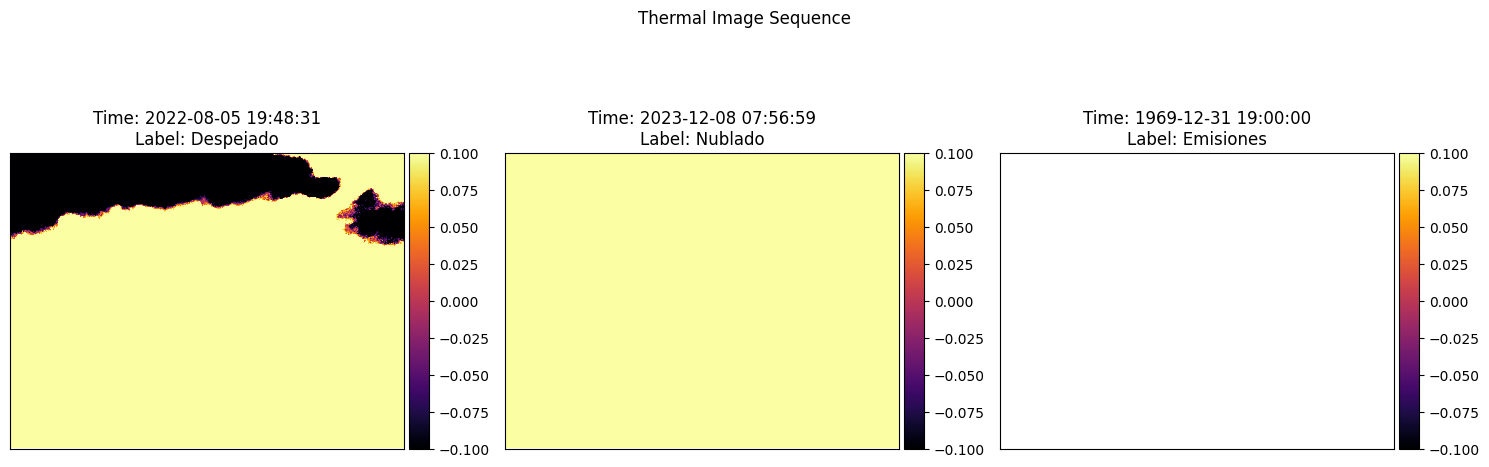

In [10]:
# Get necessary data from your dataset
timestamps = dataset['metadata']['timestamps']
numeric_labels = labels_data['numeric_labels']
label_mapping = labels_data['label_mapping']

# Get label examples and indices first
label_examples = get_label_examples(numeric_labels, label_mapping)
example_indices = list(label_examples.values())

# Then do the thermal visualization
thermal_stats = get_thermal_stats(corrected_tensor)
print_thermal_stats(thermal_stats)
visualize_thermal_sequence(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Now this is defined
    thermal_stats['global_min'],
    thermal_stats['global_max'],
    label_mapping
)


Edge Detection Statistics:
Average edge density: 0.0032
Average total edges: 975.33
Average non-zero ratio: 0.0032


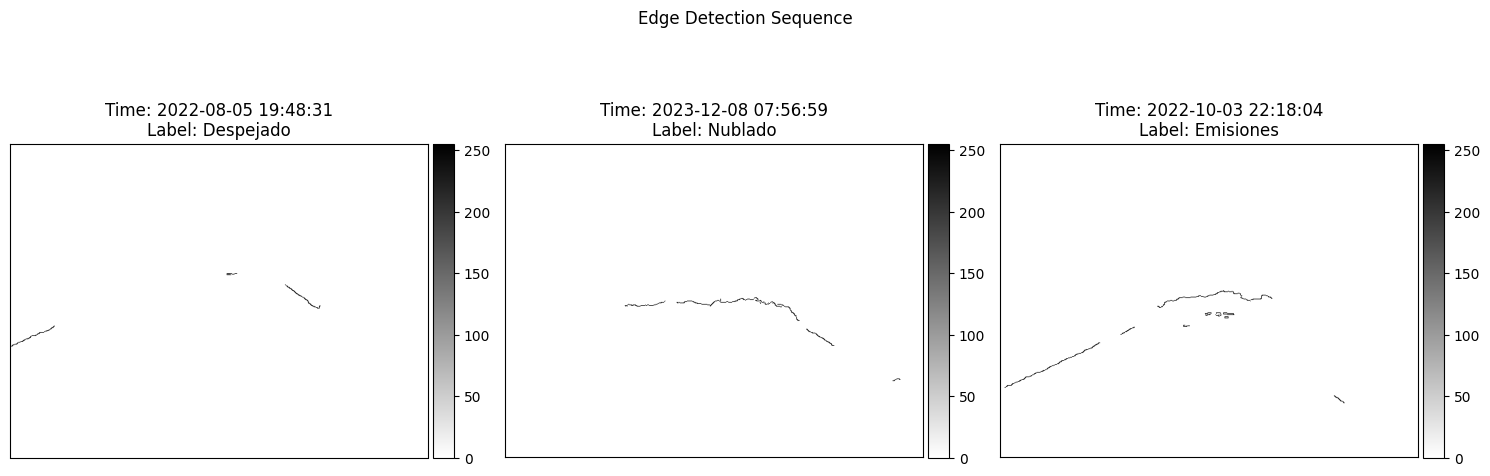

In [12]:
# Edge detection visualization and stats
edge_stats = get_edge_stats(edge_features)
print_edge_stats(edge_stats)
visualize_edge_sequence(
    edge_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices we created before
    label_mapping
)

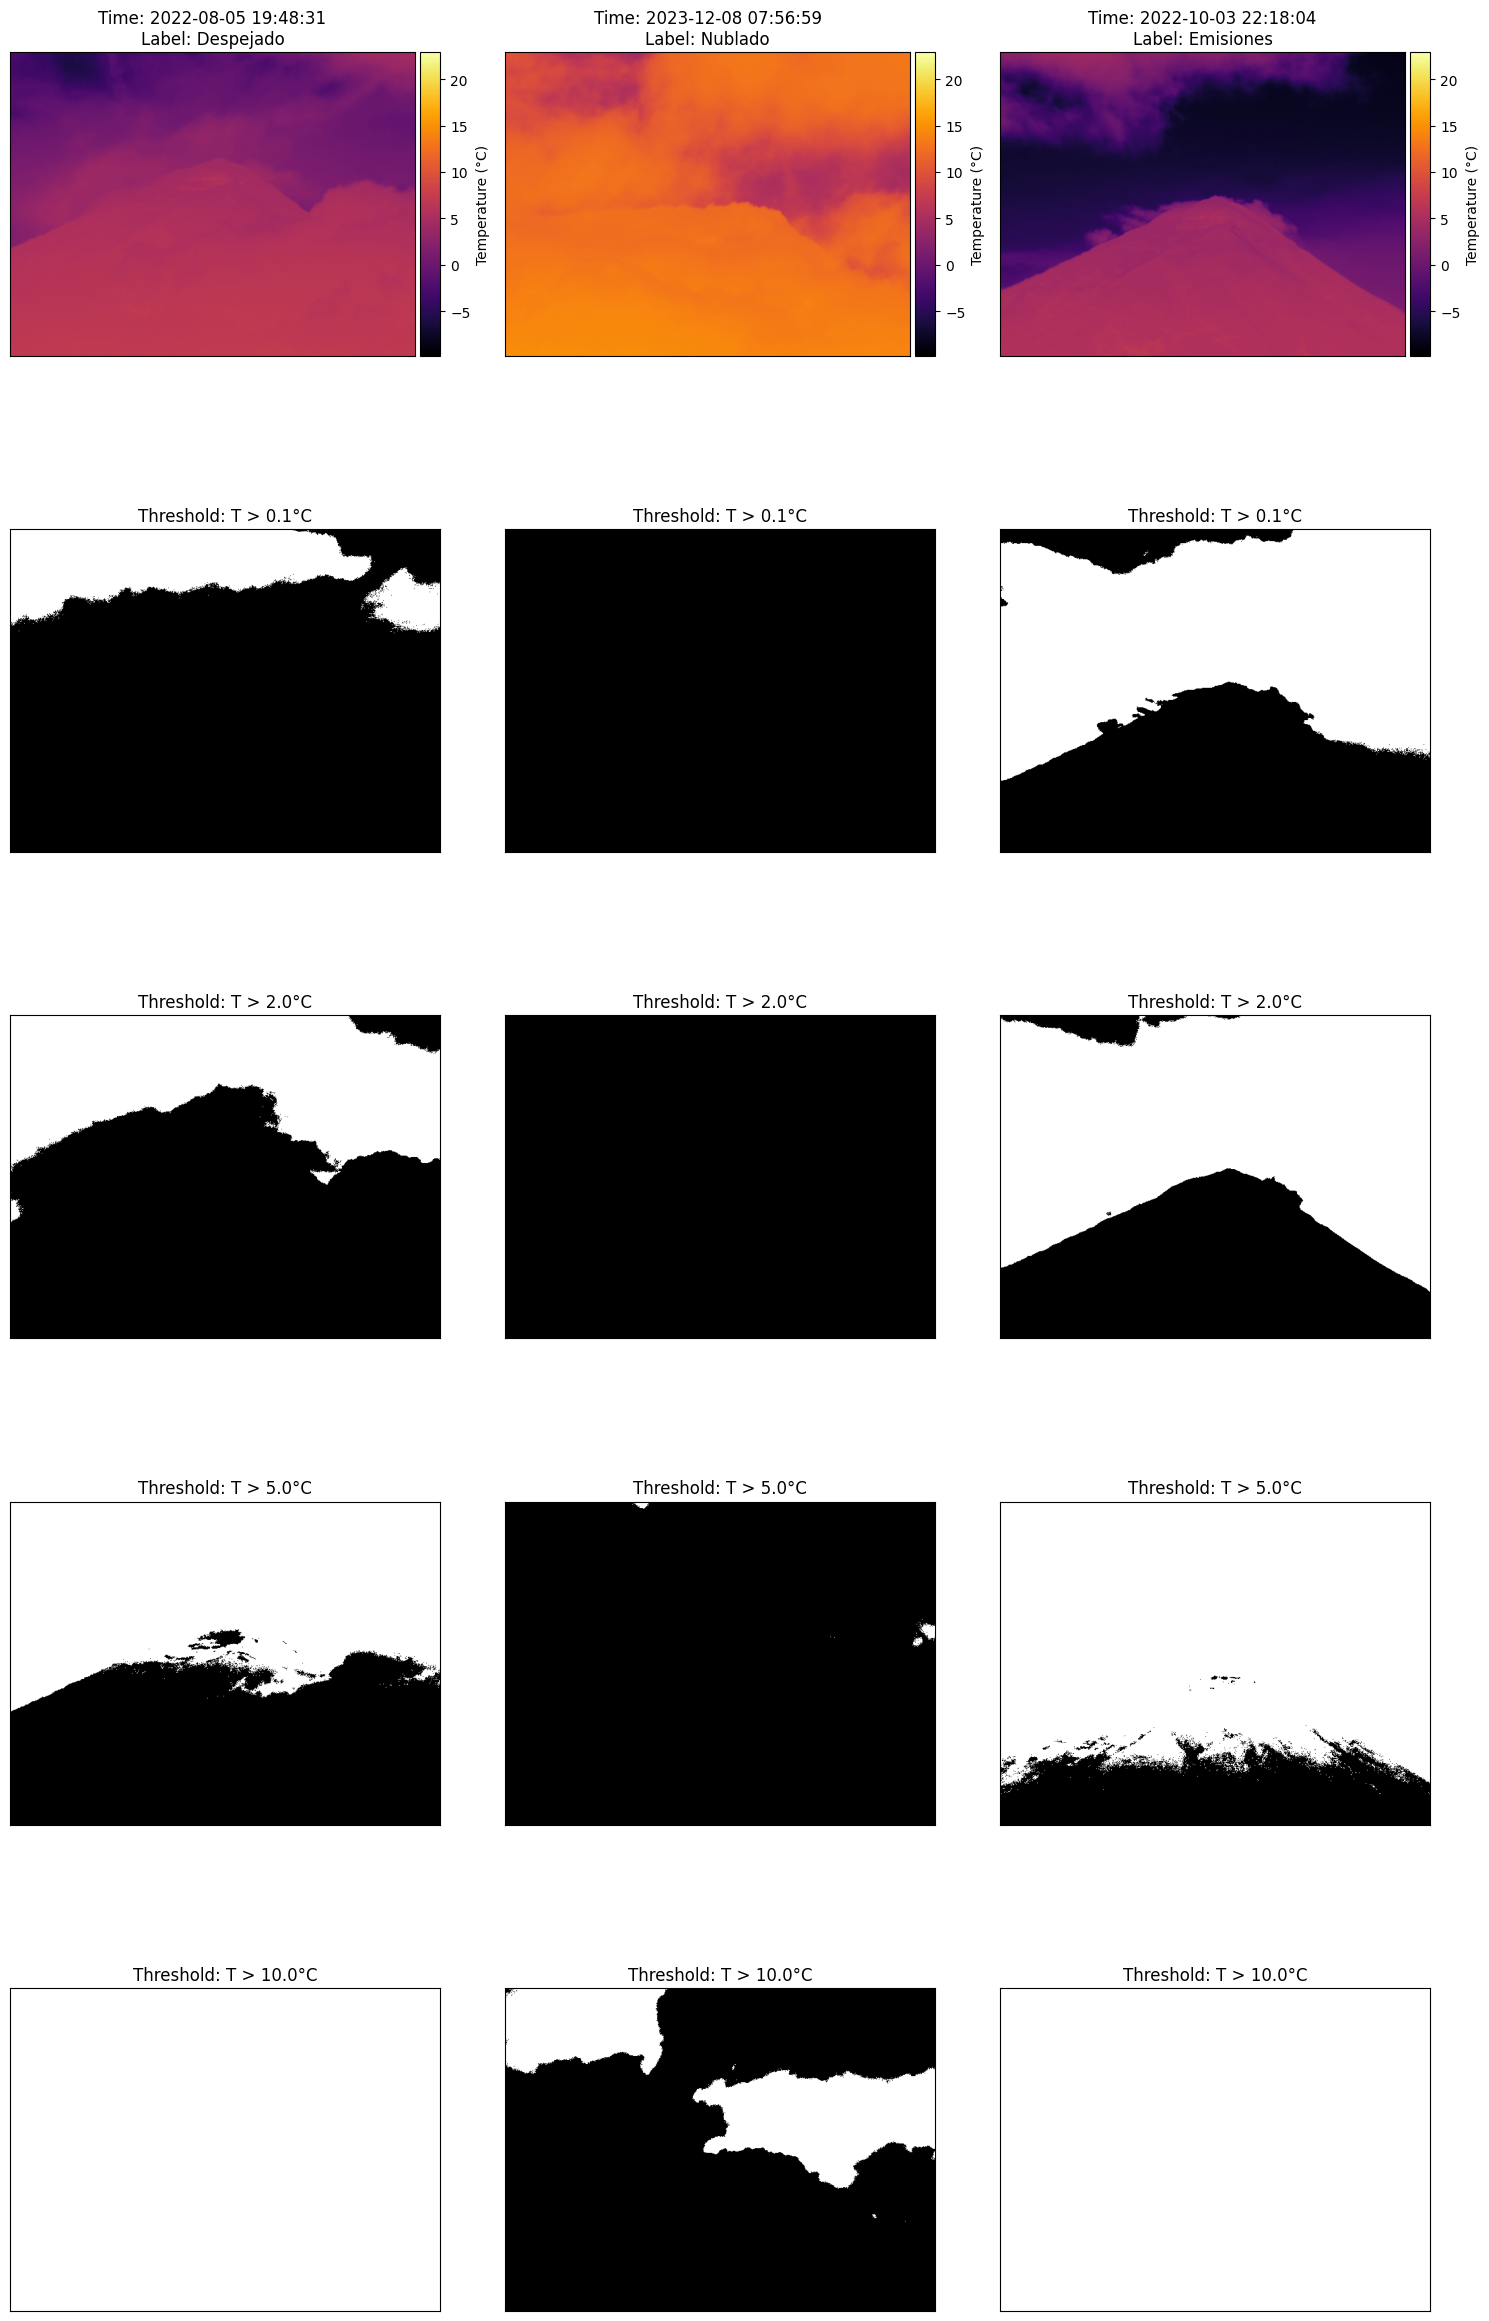

In [13]:
# Thermal threshold visualization
visualize_thermal_threshold_comparison(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices from before
    label_mapping
)